In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [29]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import pandas as pd
from IPython.display import display

from numpy import exp

from tracking.motion import ConstantVelocityModel, constant_velocity_models
from tracking.target import ConstantAccelerationTarget, ConstantVelocityTarget, SinusTarget, SingerTarget
from tracking.kalman import kalman_pv
from tracking.evaluation import monte_carlo, rmse, execute, state_residuals

from tracking.plot import boxplot_rmse, aggregated_errors, plot_aggregated_errors, plot_error_band
from tracking.util import to_df, as_png

In [4]:
from scipy import stats

# Constant-Velocity Model

## Constant-Velocity Target

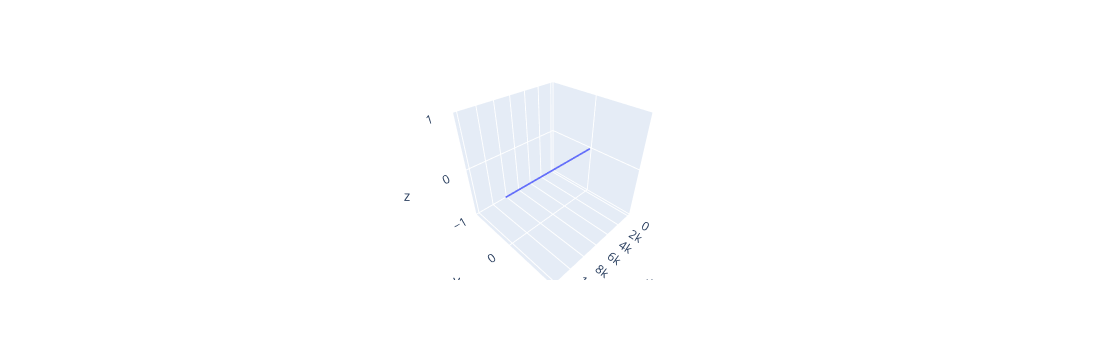

In [5]:
target = ConstantVelocityTarget()

fig = ex.scatter_3d(target.true_states_df(), x='x', y='y', z='z')
fig.update_traces(marker_size = 1)
fig

In [6]:
motion  = constant_velocity_models(0, .1 ,.5, 1, 2, 5, 10, 20)
z_sigma = [.87, 8.72, 87.2]
results = monte_carlo(target, motion, z_sigma, n=1200)

### Sample run

Let's take a sample run and inspect it a bit closer. This run was generated with a Constant Velocity (`target = cv`) target, a Constant Velocity motion model with process noise intensity $0.1$ (`motion = cv_0.1`), assumed measurement noise standard deviation $0.87$ (`R = 0.87`), actual measurement noise standard deviation $0.87$ (`z_sigma = 0.87`), and random generator seed set to $0$. 

In [7]:
r = results.select(z_sigma=.87)[50]
r

EvaluationResult {'target': 'cv', 'motion': 'cv_0.1', 'z_sigma': 0.87, 'seed': 0, 'R': 0.7569}

Next, we plot residuals of the Kalman Filter state in time. As expected, after the initial period of larger errors in the `x` dimension, when Kalman Filter converges on the true velocity, residuals seem to oscilate around zero.

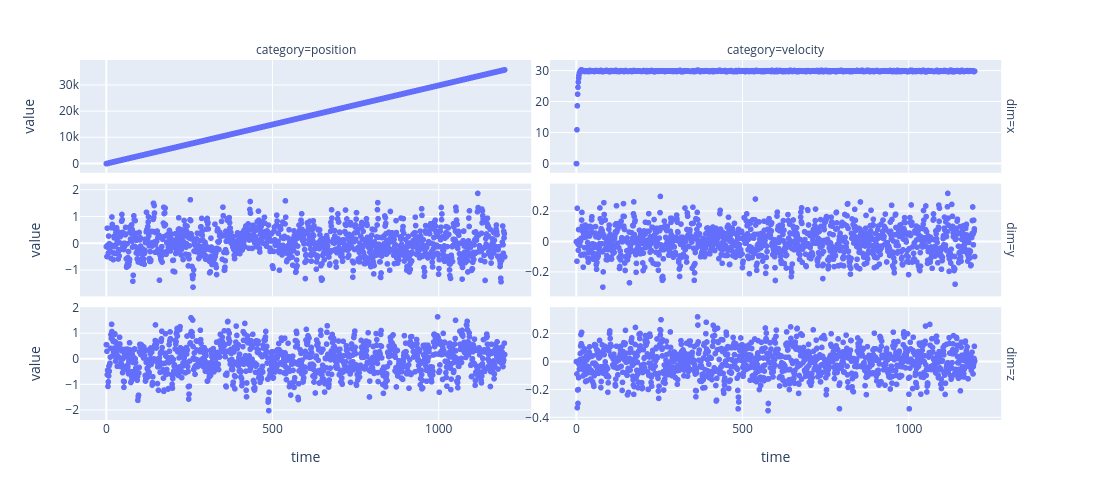

In [8]:
df = r.x_hat_df.melt(id_vars=['time'], var_name='dim')
df['category'] = df.dim.apply(lambda x: 'velocity' if x.startswith('v') else 'position')
df['dim'] = df.dim.apply(lambda x: x[1:] if x.startswith('v') else x)

fig = ex.scatter(df, x='time', y='value', facet_col='category', facet_row='dim')
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig)

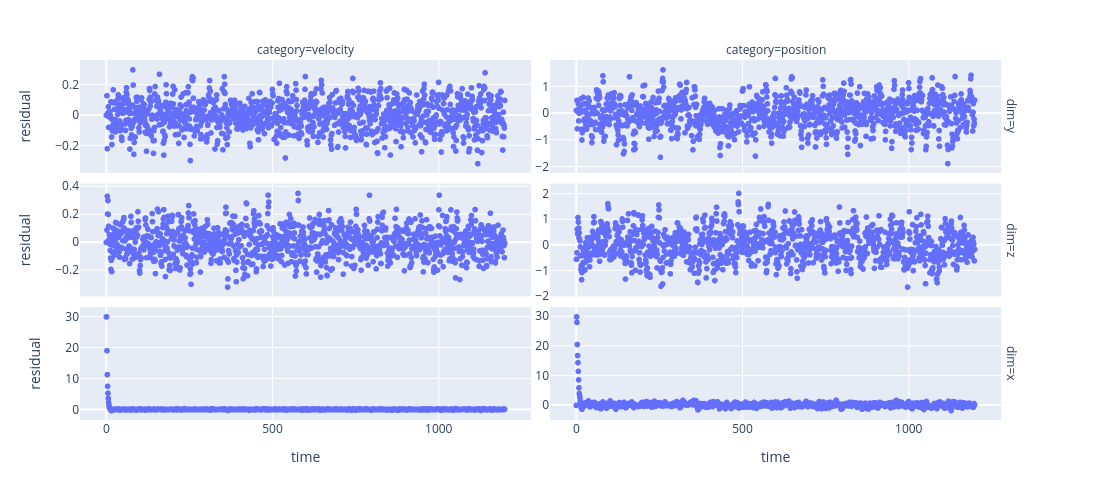

In [9]:
err = state_residuals(r)
fig = ex.scatter(err, x='time', y='residual', facet_col='category', facet_row='dim')
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig)

We confirm that by plotting the histogram of each error.

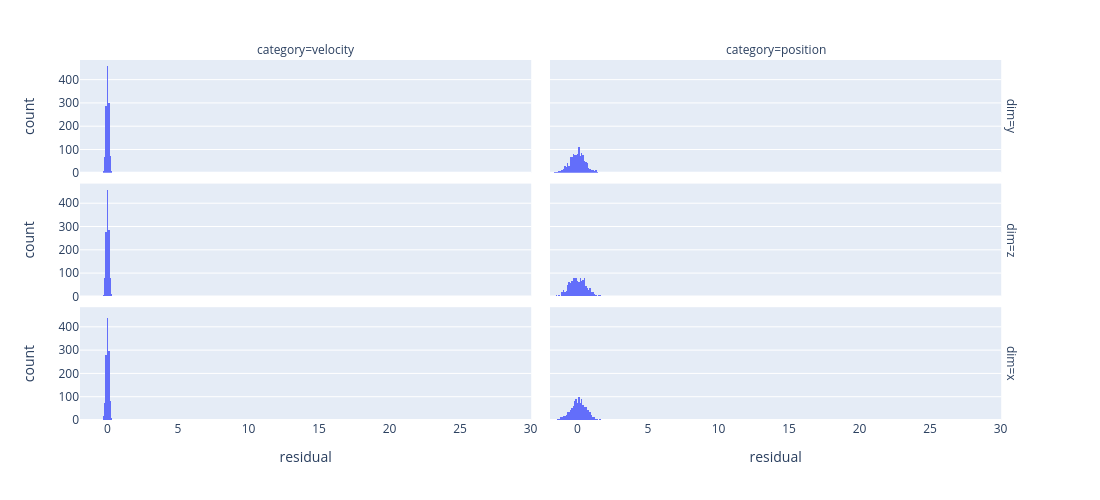

In [10]:
fig = ex.histogram(err, x='residual', facet_col='category', facet_row='dim')
as_png(fig)

Finally, we get rid of the outliers from the initial period.

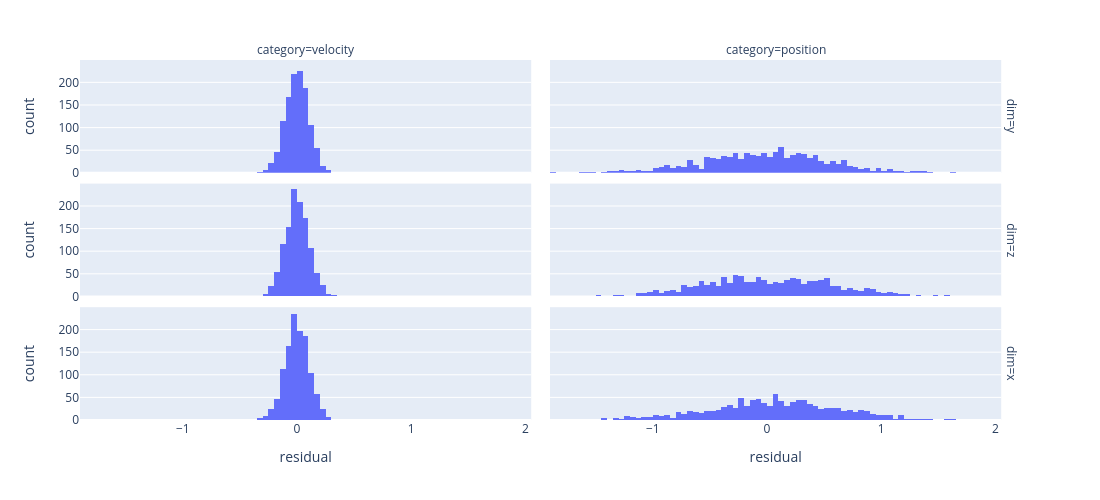

In [11]:
fig = ex.histogram(err.query('time > 30'), x='residual', facet_col='category', facet_row='dim')
as_png(fig)

Let's see if those shapes will look better if let the algorithm run for more than 400 iterations.

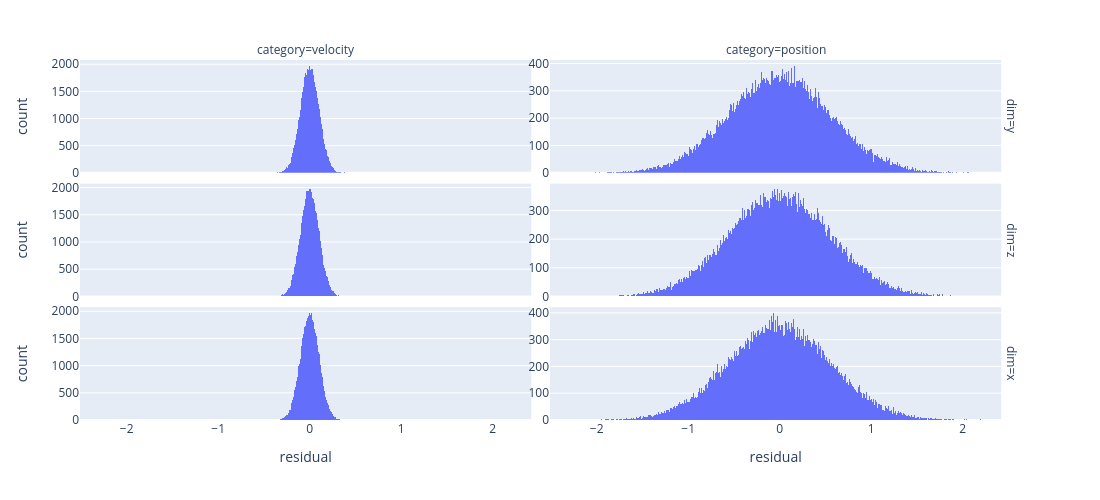

In [12]:
err = state_residuals(execute(r.copy(n=50000)))
fig = ex.histogram(err.query('time > 30'), x='residual', facet_col='category', facet_row='dim')
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig)

In [13]:
trace = []
for name, group in err.query('time > 500').groupby(by=['category', 'dim']):
    #res = stats.goodness_of_fit(stats.norm, group.residual, statistic='ad', random_state=np.random.default_rng())
    #trace.append(name + (res.pvalue, round(res.fit_result.params.loc, 5), round(res.fit_result.params.scale, 5)))

    loc, scale = np.mean(group.residual), np.std(group.residual, ddof=1)
    cdf = stats.norm(loc, scale).cdf
    res = stats.ks_1samp(group.residual, cdf)

    trace.append(name + (res.pvalue, round(loc, 5), round(scale, 5)))
    
to_df(trace, columns=['category', 'dim', 'pvalue', 'loc', 'scale'])

category dim              pvalue       loc    scale
0  position   x  0.9518581940698541  -0.00382  0.56566
1  position   y  0.6300782378009183   0.00262   0.5651
2  position   z  0.5959799458208951   0.00313  0.56512
3  velocity   x  0.8399989005029758    -1e-05  0.10171
4  velocity   y  0.7396882783255785       0.0  0.10178
5  velocity   z  0.9024339332061957    -1e-05  0.10161

From the above we see that all dimensions of the Kalman Filter state are distributed normally, with zero mean and standard deviation equal across position and velocity elements.

## Verify measurements

In [14]:
x = execute(results[0].copy(n=10000))
x.z_sigma, np.sqrt(x.R), np.std((x.z - x.truth[:,:3]), axis=0)

(0.87, 0.87, array([0.86803687, 0.8576075 , 0.87661558]))

## Error aggregated across random seeds

Now we plot Euclidean-distance error as a function of time, aggregated over simulated runs where only the random seed is different between each run.

In [15]:
def aggregate_errors(group):
    skip = 0
    pos = [np.sqrt(np.power(r.truth[skip:,:3] - r.x_hat[skip:,:3], 2).sum(axis=1)) for r in group]
    vel = [np.sqrt(np.power(r.truth[skip:,3:6] - r.x_hat[skip:,3:6], 2).sum(axis=1)) for r in group]
    df = pd.DataFrame(dict(time=np.arange(pos[0].shape[0]), pos=np.array(pos).T.mean(axis=1), vel=np.array(vel).T.mean(axis=1)))
    return df.melt(['time'], None, 'category', 'error')

# group by everything except the random seed
data = results.group_by(['target', 'motion', 'z_sigma', 'R']).apply_df(aggregate_errors)

As illustrated in the plot below, each configuration of `z_sigma` and `motion` has a different "steady-state" variance and a different time until it reaches that "steady-state" level. The lower the combined measurement and process noise, the longer it takes until the "steady-state" variances is reached, but also the lower that final value is.

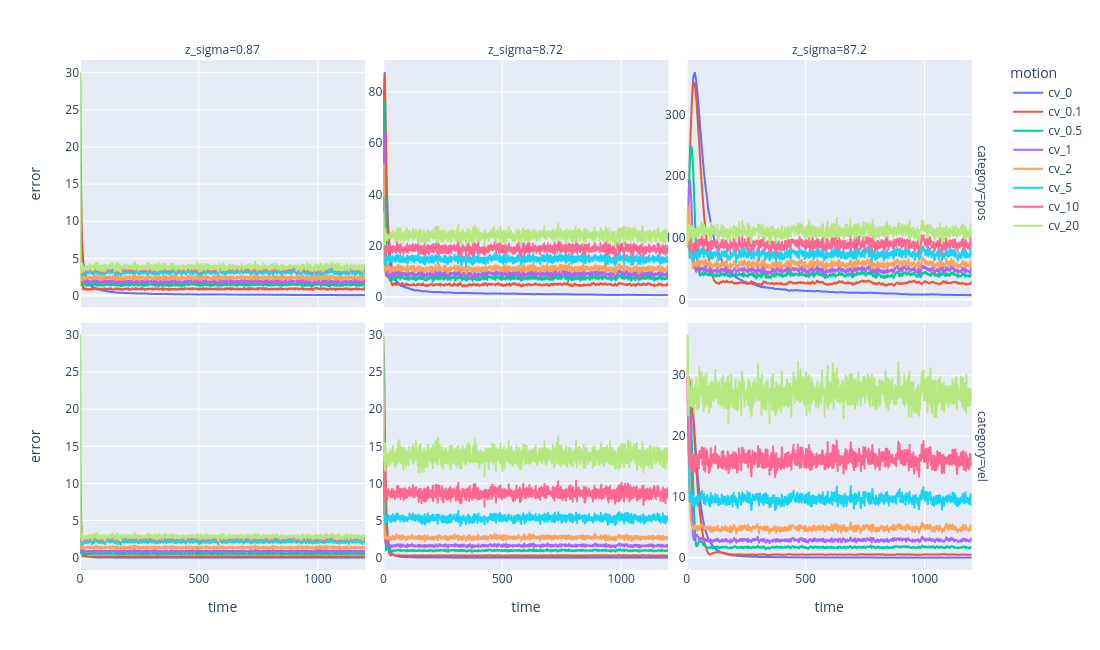

In [16]:
fig = ex.line(data, x='time', y='error', color='motion', facet_col='z_sigma', facet_row='category')
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig, height=650)

First, let's zoom into the initial period where each instance of the Kalman Filter converges towards its steady-state level. We do that by changing the X axis to the logarithmic scale.

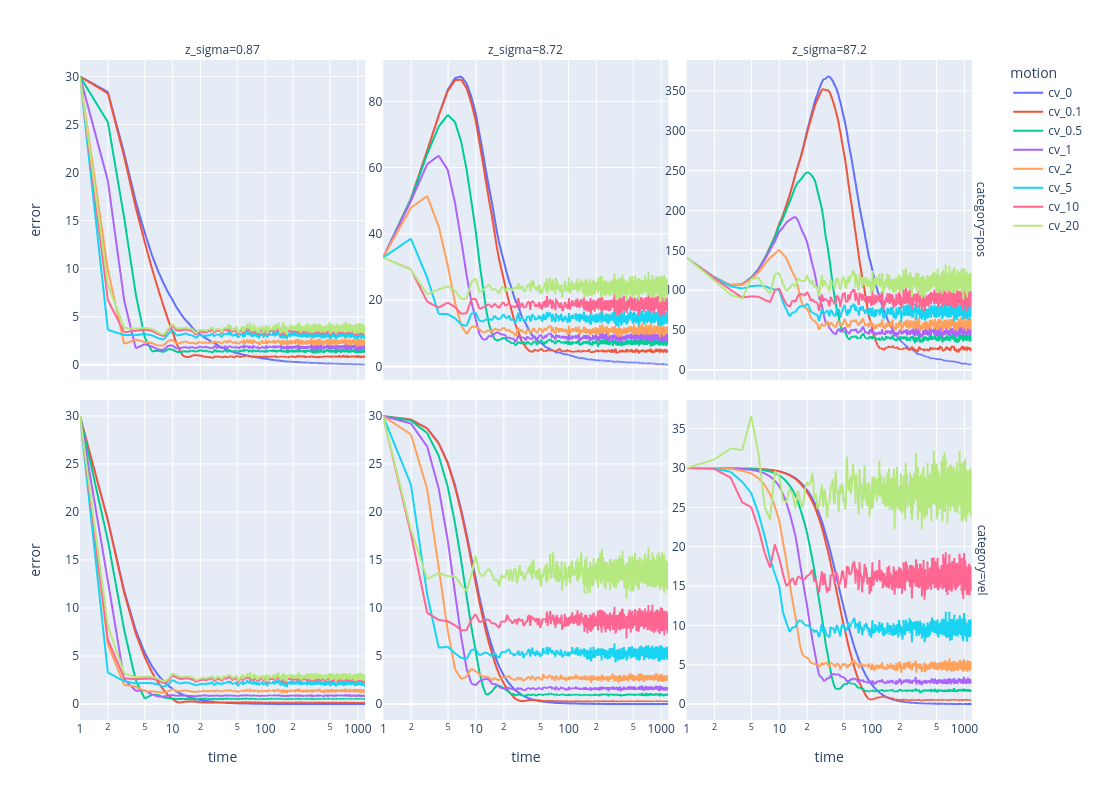

In [17]:
fig = ex.line(data, x='time', y='error', color='motion', facet_col='z_sigma', facet_row='category', log_x=True)
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig, height=800)

Now, let's zoom into the steady-state part by selecting for `time` larger than 600.

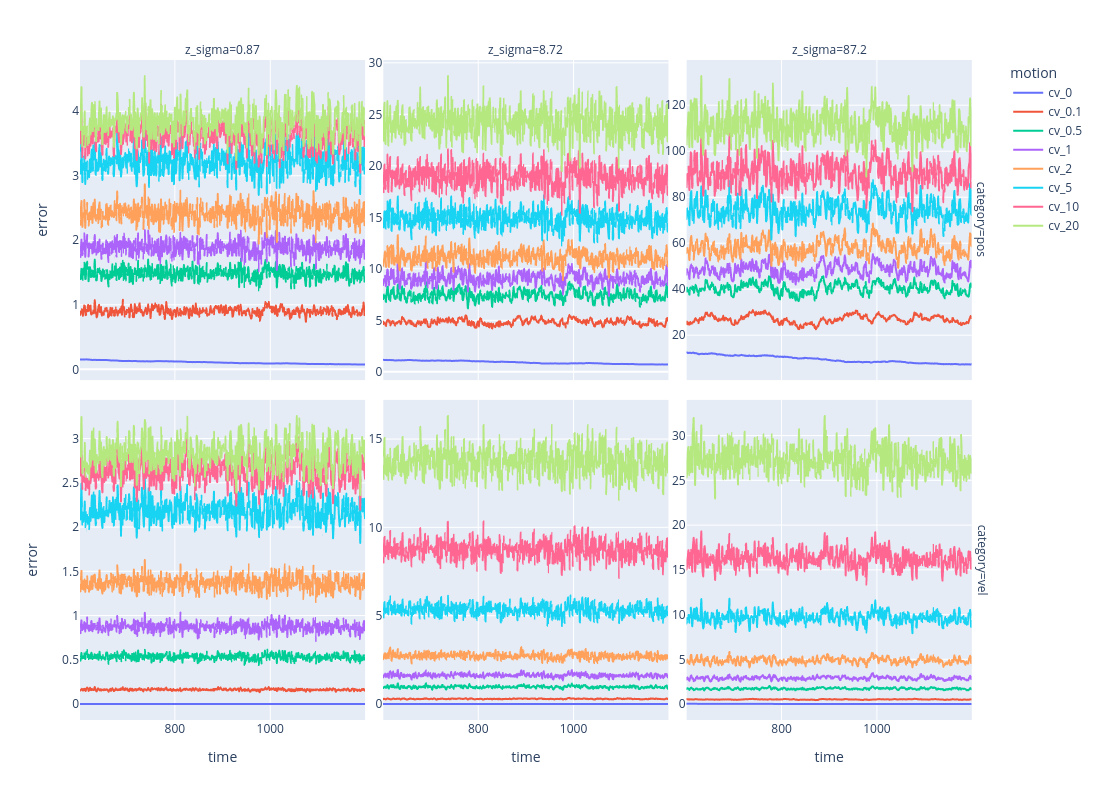

In [18]:
fig = ex.line(data.query('time > 600'), x='time', y='error', color='motion', facet_col='z_sigma', facet_row='category')
fig.update_yaxes(matches=None, showticklabels=True)
as_png(fig, height=800)

Let's also look at histograms of these values for `time > 600`.

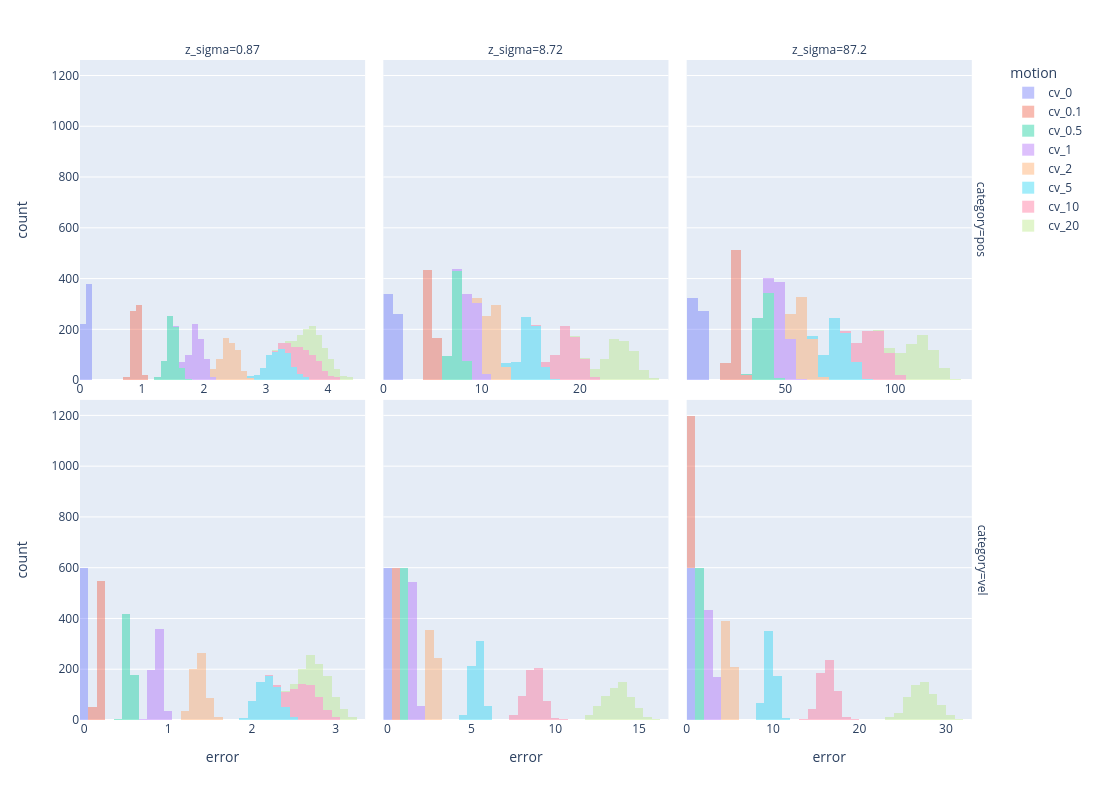

In [19]:
fig = ex.histogram(data.query('time > 600'), x='error', color='motion', facet_col='z_sigma', facet_row='category', nbins=50)
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_traces(bingroup=None)
fig.update_traces(opacity=.4)
as_png(fig, height=800)

Finally, let's plot the steady-state mean error as a function of `z_sigma` and the motion model.

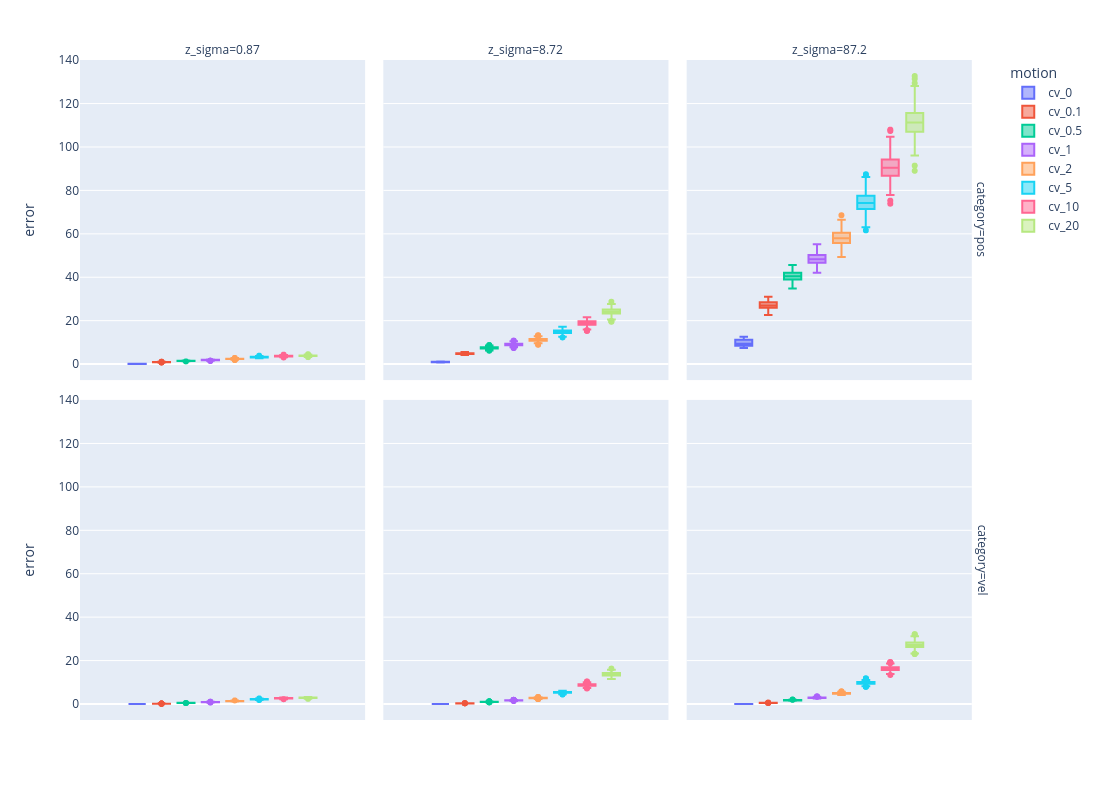

In [20]:
fig = ex.box(data.query('time > 600'), y='error', color='motion', facet_col='z_sigma', facet_row='category')
fig.update_xaxes(matches=None, showticklabels=True)
as_png(fig, height=800)

**TODO**: this can be derived in a closed form

## Error in each dimension

Let's check what does the error distribution look like in each dimension separately. We expect to see normally distributed error with zero mean.

#### Position

In [21]:
def position_residuals(group):
    parts = []
    for r in group:
        # calculate residuals of position but skip the first 100 points
        err = r.truth[:,:3] - r.x_hat[:,:3]
        parts.append(to_df(err[600:,:], columns=['x','y','z']))
    return pd.concat(parts).melt(var_name='dim', value_name='residual')

data = results.group_by(['target', 'motion', 'z_sigma', 'R']).apply_df(position_residuals)

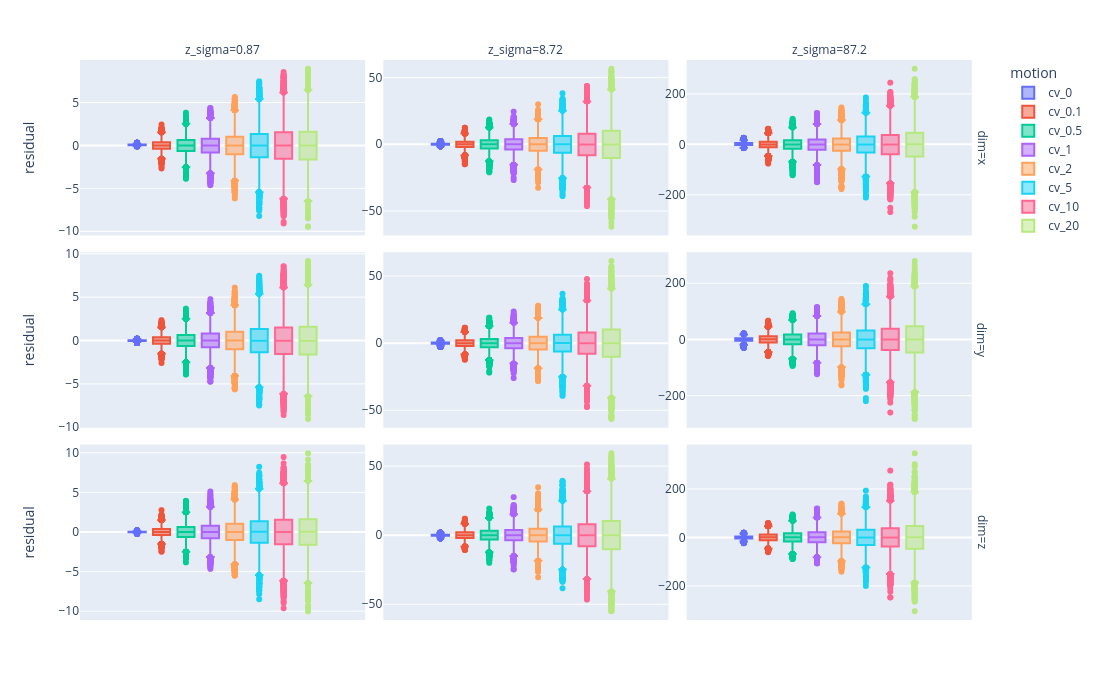

In [22]:
fig = ex.box(data, y='residual', color='motion', facet_col='z_sigma', facet_row='dim')
fig.update_traces(quartilemethod="exclusive")
fig.update_xaxes(type='category')
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(height=700)
as_png(fig)

#### Velocity

Similarily, in case of velocity we expect normally distributed estimation error with zero mean. Standard deviation will be lower than in the case of position estimation errror.

In [23]:
def velocity_residuals(group):
    parts = []
    for r in group:
        # calculate residuals of position but skip the first 100 points
        err = r.truth[:,3:] - r.x_hat[:,3:]
        parts.append(to_df(err[600:,:], columns=['x','y','z']))
    return pd.concat(parts).melt(var_name='dim', value_name='residual')

data = results.group_by(['target', 'motion', 'z_sigma', 'R']).apply_df(velocity_residuals)

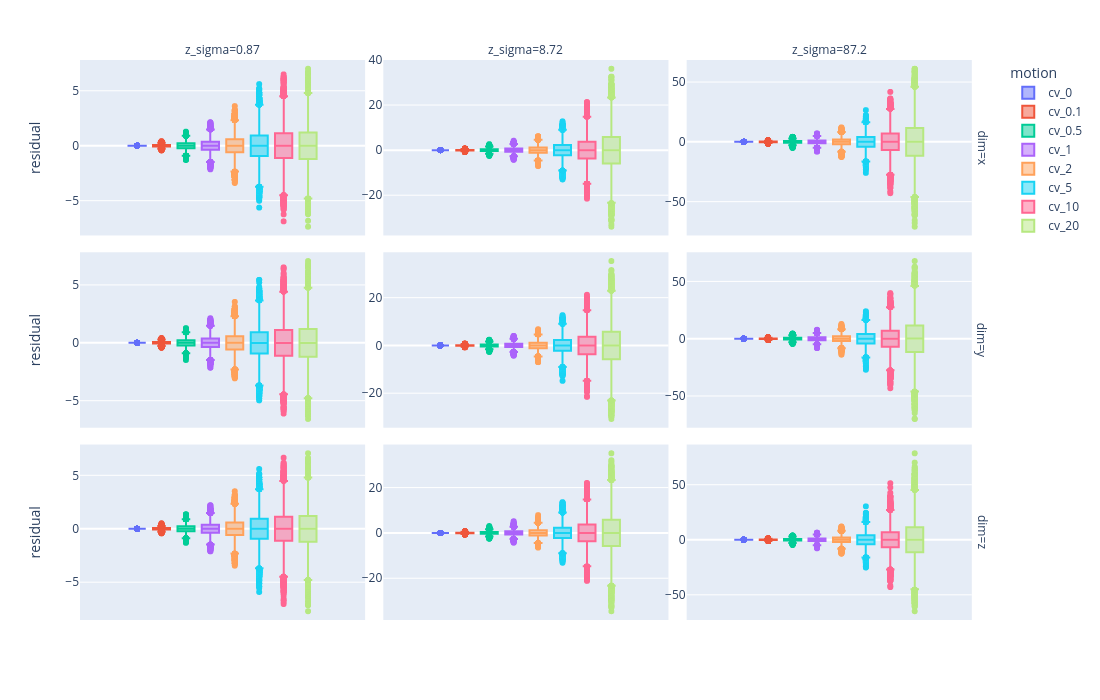

In [24]:
fig = ex.box(data, y='residual', color='motion', facet_col='z_sigma', facet_row='dim')
fig.update_traces(quartilemethod="exclusive")
fig.update_xaxes(type='category')
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(height=700)
as_png(fig)

### RMSE

Root mean squared error (RMSE) calculates the L2 norm of the difference between the estimated and the true position and velocity.

In [25]:
def rmse(group):
    skip = 600
    dims = min(group[0].truth.shape[1], group[0].x_hat.shape[1])
    errs = []
    for r in group:
        err = r.truth[skip:,:dims] - r.x_hat[skip:,:dims]
        pos = np.sqrt(np.power(err[:,:3], 2).sum(axis=1).mean(axis=0))
        vel = np.sqrt(np.power(err[:,3:6], 2).sum(axis=1).mean(axis=0))
        errs.append((pos, vel))
    return to_df(errs, columns=['pos', 'vel']).melt(var_name='category', value_name='rmse')

data = results.group_by(['target', 'motion', 'z_sigma', 'R']).apply_df(rmse)

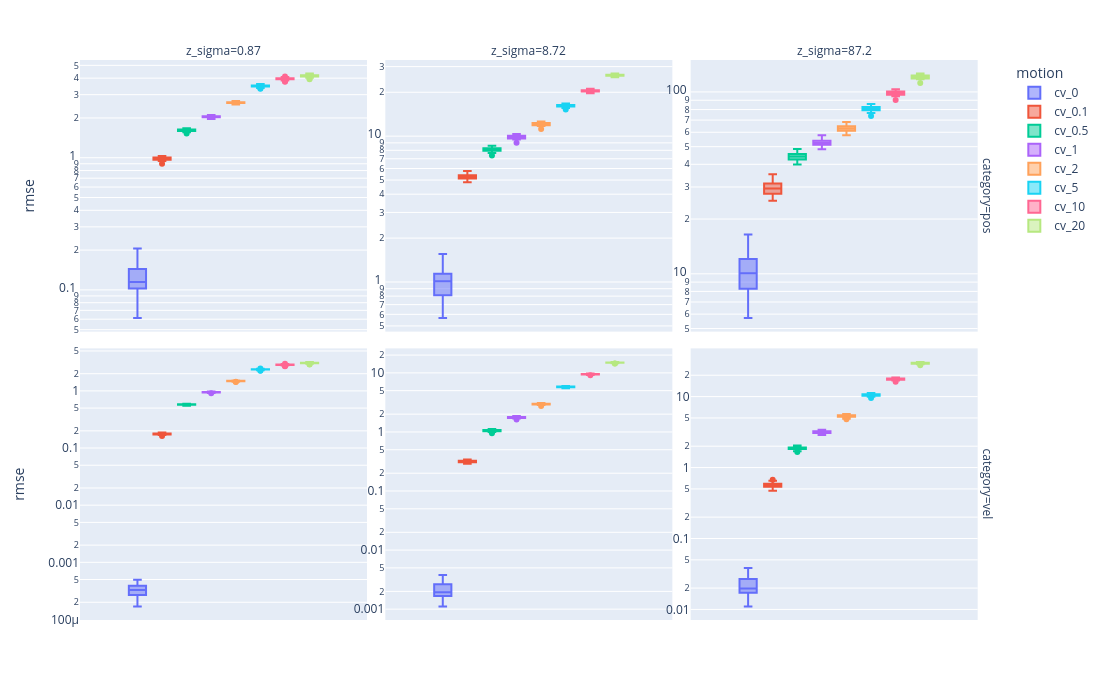

In [26]:
fig=ex.box(data, y='rmse', color='motion', facet_col='z_sigma', facet_row='category', log_y=True)
fig.update_xaxes(type='category')
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(height=700)
fig

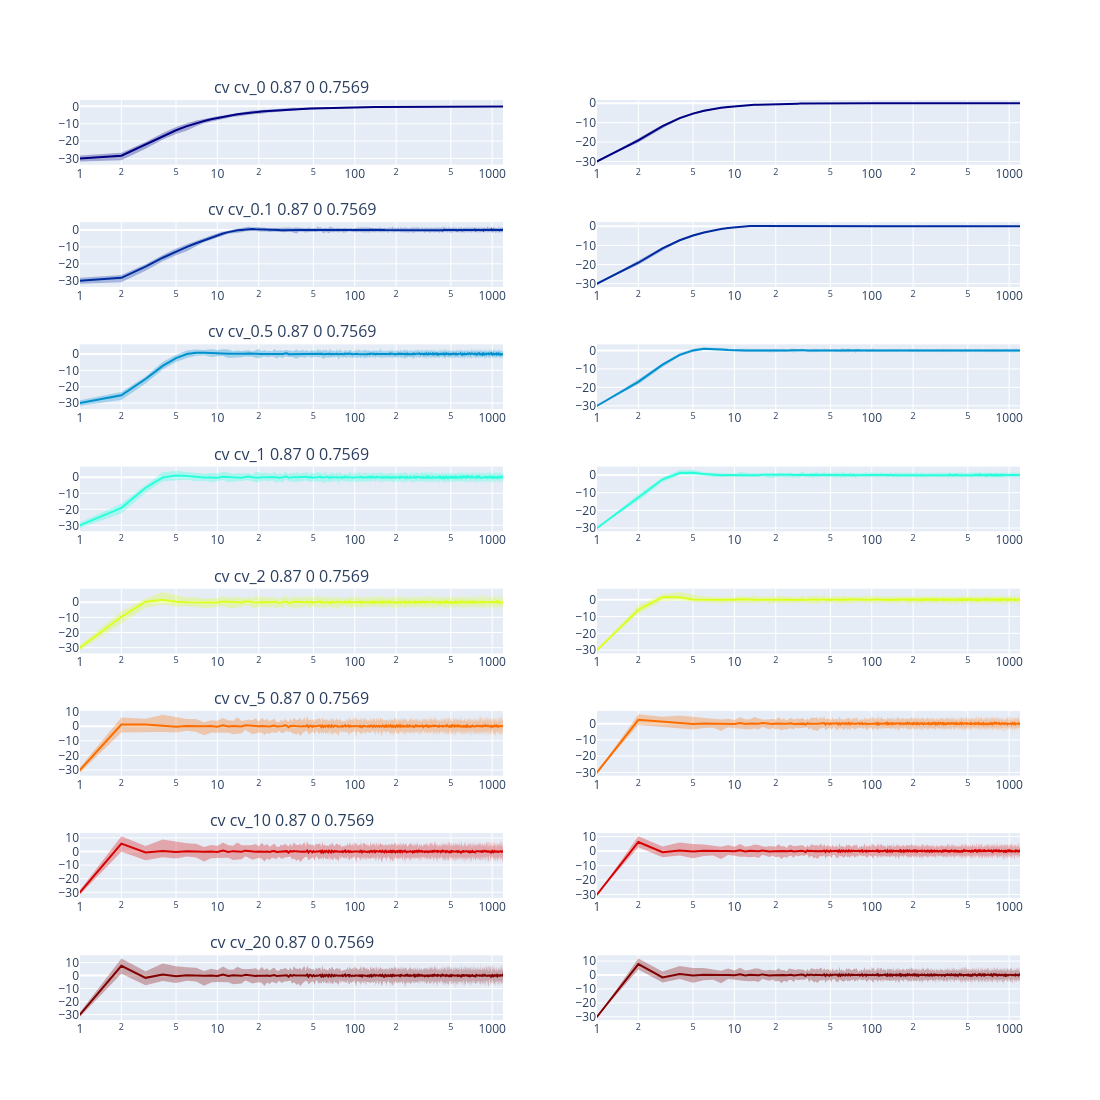

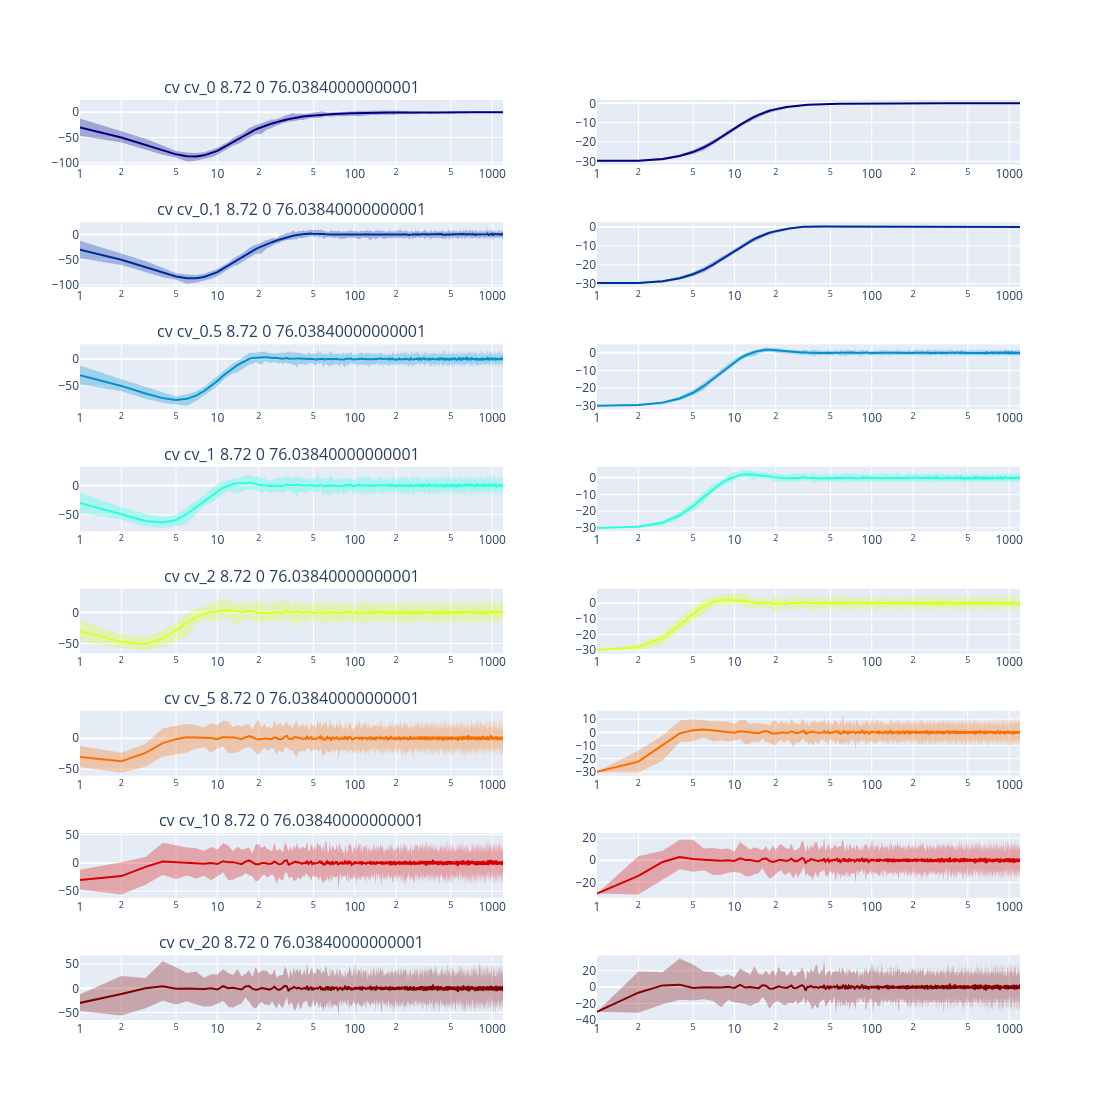

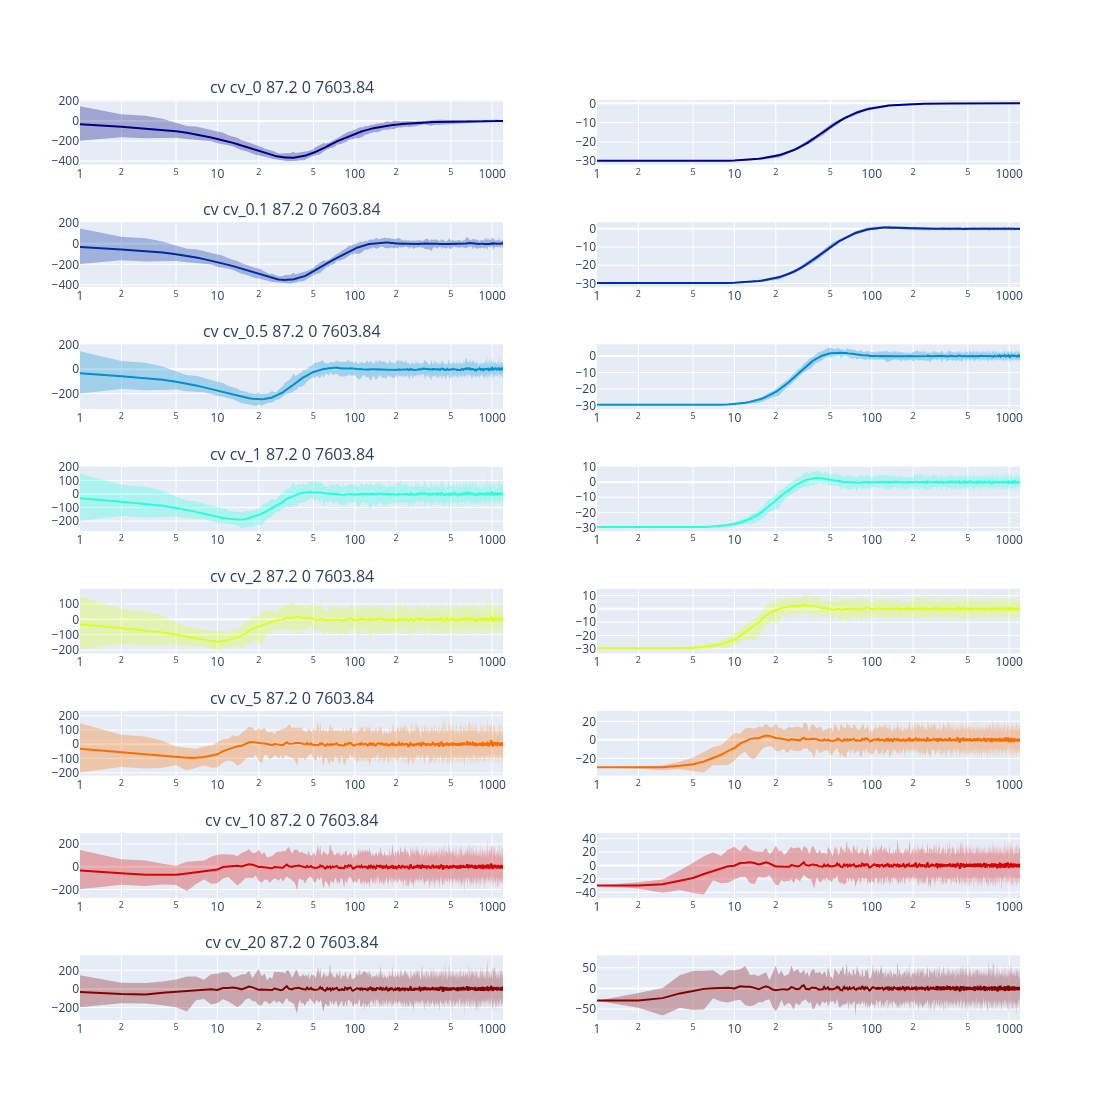

In [31]:
for zs in z_sigma:
    fig = plot_error_band(results.select(z_sigma=zs).group_by(exclude='seed'))
    fig.update_xaxes(type="log")
    display(as_png(fig, height=1100))